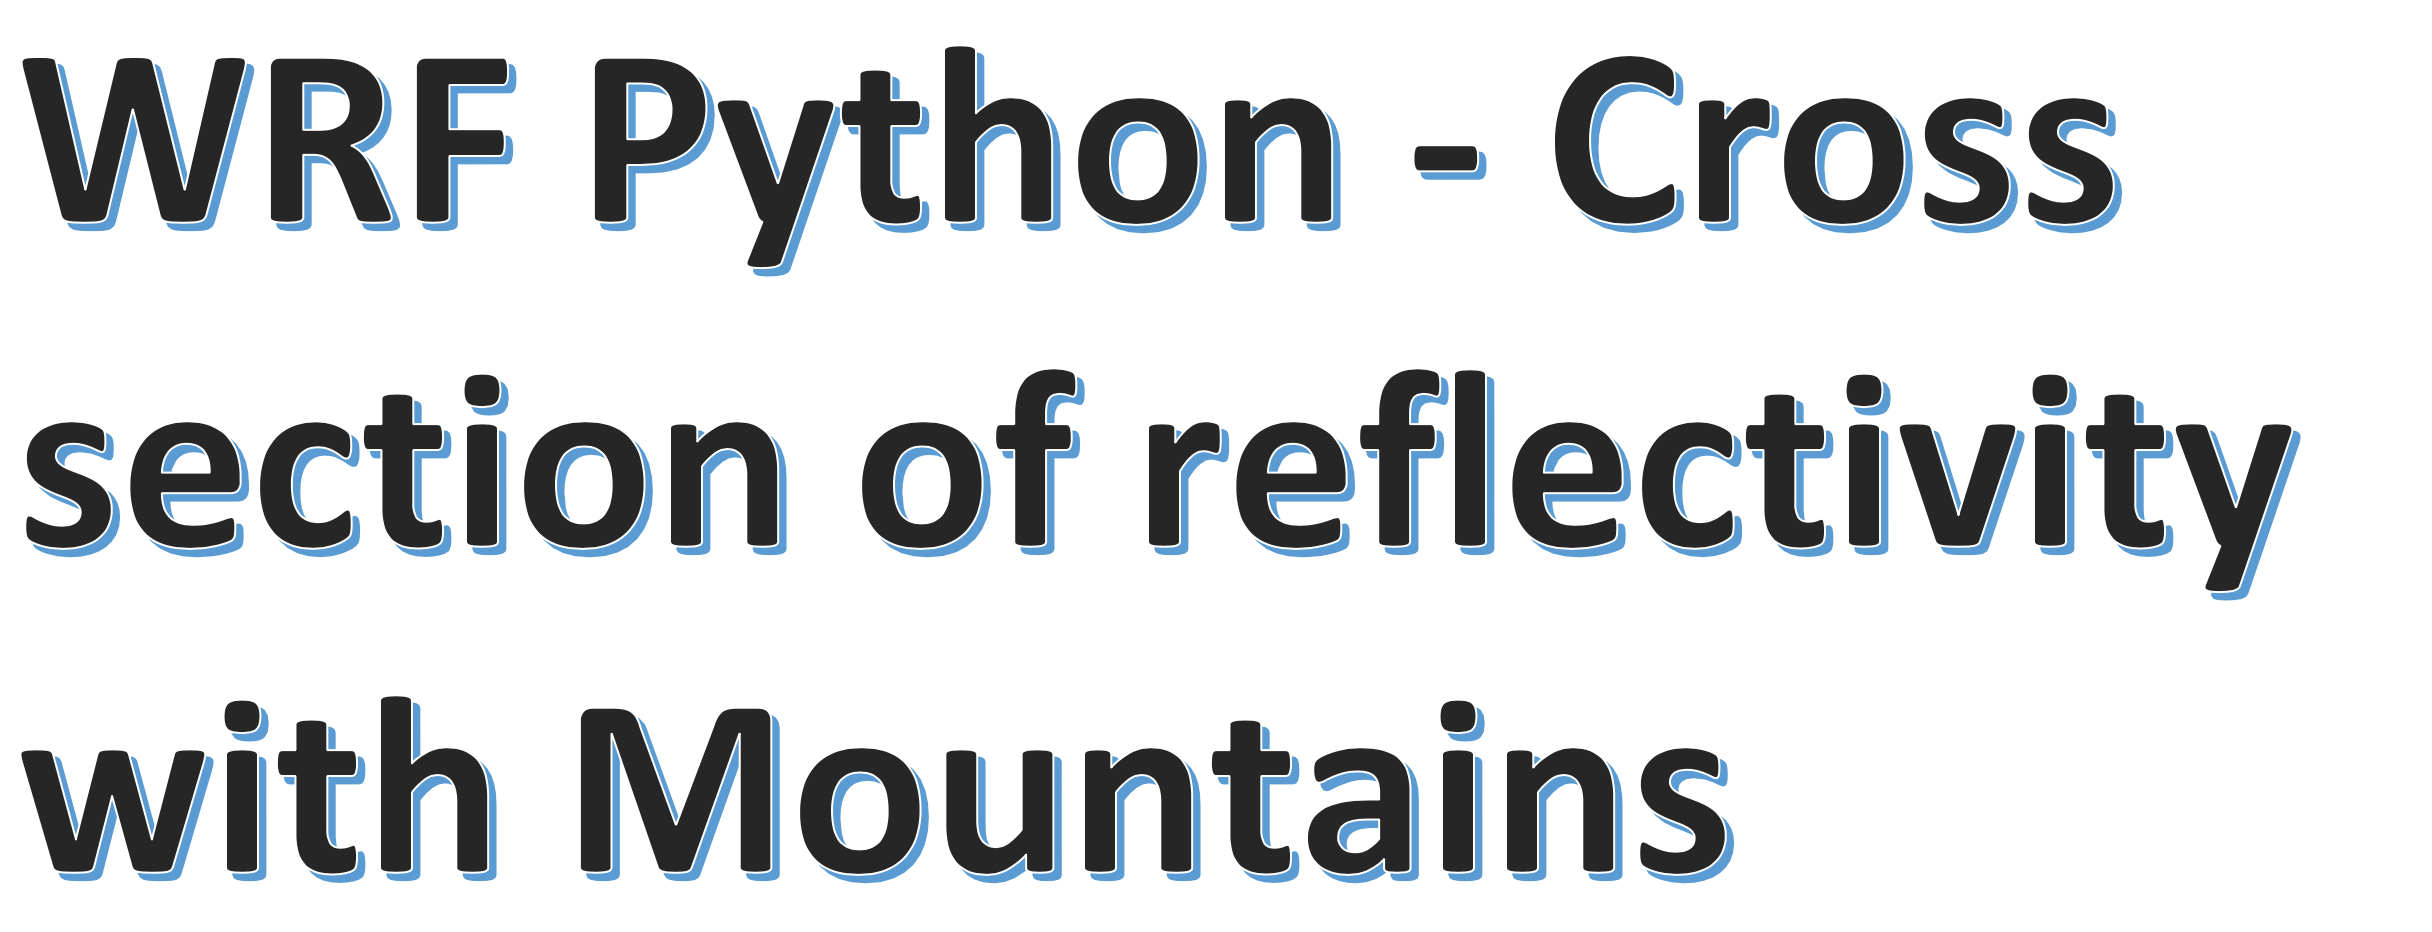

In [5]:
from IPython.display import Image
Image('08overview.png')

In this tutorial, we will learn how to plot a cross section with mountain height plot for a particular output of WRF model.
Referrence: 
https://wrf-python.readthedocs.io/en/latest/index.html

# 1. Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair)

# 2. Download data

In [2]:
# specify where is the location of the data
path_in = "data/"
path_out = "./"
# Open the NetCDF file
ncfile = Dataset(path_in + 'wrfout_d03_2018-08-03_16_30_00.nc')

# 3. Take out the variables

In [3]:
# Define the cross section start and end points
cross_start = CoordPair(lat=-35.9, lon=145.5)
cross_end   = CoordPair(lat=-35.9, lon=150)

# Get the WRF variables
ht  = getvar(ncfile, "z", timeidx=-1)
ter = getvar(ncfile, "ter", timeidx=-1)
dbz = getvar(ncfile, "dbz", timeidx=-1)
max_dbz = getvar(ncfile, "mdbz", timeidx=-1)
Z = 10**(dbz/10.) # Use linear Z for interpolation

# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section in the metadata by setting latlon
# to True.
z_cross = vertcross(Z, ht, wrfin=ncfile,
                    start_point=cross_start,
                    end_point=cross_end,
                    latlon=True, 
                    meta=True)

# Convert back to dBz after interpolation
dbz_cross = 10.0 * np.log10(z_cross)

# Add back the attributes that xarray dropped from the operations above
dbz_cross.attrs.update(z_cross.attrs)
dbz_cross.attrs["description"] = "radar reflectivity cross section"
dbz_cross.attrs["units"] = "dBZ"

# To remove the slight gap between the dbz contours and terrain due to the
# contouring of gridded data, a new vertical grid spacing, and model grid
# staggering, fill in the lower grid cells with the first non-missing value
# for each column.

# Make a copy of the z cross data. Let's use regular numpy arrays for this.
dbz_cross_filled = np.ma.copy(to_np(dbz_cross))

# For each cross section column, find the first index with non-missing
# values and copy these to the missing elements below.
for i in range(dbz_cross_filled.shape[-1]):
    column_vals = dbz_cross_filled[:,i]
    # Let's find the lowest index that isn't filled. The nonzero function
    # finds all unmasked values greater than 0. Since 0 is a valid value
    # for dBZ, let's change that threshold to be -200 dBZ instead.
    first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
    dbz_cross_filled[0:first_idx, i] = dbz_cross_filled[first_idx, i]

# Get the terrain heights along the cross section line
ter_line = interpline(ter, wrfin=ncfile, start_point=cross_start,
                      end_point=cross_end)

# Get the lat/lon points
lats, lons = latlon_coords(dbz)

# Get the cartopy projection object
cart_proj = get_cartopy(dbz)

# 4. Plotting

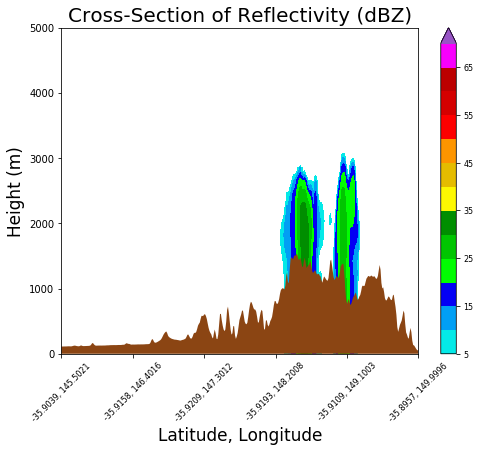

In [4]:
# Create the figure
fig = plt.figure(figsize=(8,6))
ax_cross = plt.axes()

dbz_levels = np.arange(5., 75., 5.)

# Create the color table found on NWS pages.
dbz_rgb = np.array([[4,233,231],
                    [1,159,244], [3,0,244],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198]], np.float32) / 255.0

dbz_map, dbz_norm = from_levels_and_colors(dbz_levels, dbz_rgb,
                                           extend="max")

# Make the cross section plot for dbz
dbz_levels = np.arange(5.,75.,5.)
xs = np.arange(0, dbz_cross.shape[-1], 1)
ys = to_np(dbz_cross.coords["vertical"])
dbz_contours = ax_cross.contourf(xs,
                                 ys,
                                 to_np(dbz_cross_filled),
                                 levels=dbz_levels,
                                 cmap=dbz_map,
                                 norm=dbz_norm,
                                 extend="max")
# Add the color bar
cb_dbz = fig.colorbar(dbz_contours, ax=ax_cross)
cb_dbz.ax.tick_params(labelsize=8)

# Fill in the mountain area
ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line),
                                facecolor="saddlebrown")

# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]

# Set the desired number of x ticks below
num_ticks = 5
thin = int((len(x_ticks) / num_ticks) + .5)
ax_cross.set_xticks(x_ticks[::thin])
ax_cross.set_xticklabels(x_labels[::thin], rotation=45, fontsize=8)

# Set the x-axis and  y-axis labels
ax_cross.set_xlabel("Latitude, Longitude", fontsize=17)
ax_cross.set_ylabel("Height (m)", fontsize=17)

# Set the range of y-axis
ax_cross.set_ylim([0,5000])

# Add a title
ax_cross.set_title("Cross-Section of Reflectivity (dBZ)", {"fontsize" : 20})

plt.show()

## All done !!!
- Please feel free to let me know if there is any analysis that you would like me to do
- Please subscribe my youtube channel too
- Thank you very much